<a href="https://colab.research.google.com/github/integer-class/machine-learning/blob/main/Dicha_Zelianivan_Arkana/quiz_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step 1

First step we'll import every library we're going to need.

- `numpy`: library to process multidimentional array / dataframe
- `pandas`: library to read large data
- `sklearn`: machine learning library with a lot of useful utilities
- `matplotlib`: a dataviz library
- `seaborn`: also a dataviz library



In [1]:
# Import Required Library
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

## Step 2

In this step we'll load the dataset using the function provided by SKLearn, we'll load the LFW dataset using the `fetch_lfw_people` function with minimum faces per person of 100.

We then check the detail of the data.

In [10]:
# Load Dataset
# We will load dataset only for faces with contain min 10 images
# We also want to keep images in color; color=True
faces = fetch_lfw_people(min_faces_per_person=60, color=True)

# Check Faces
print(f'Total Label: {len(faces.target_names)}')
print(f'Data dimension: {faces.images.shape}')
print(f'Images flatten dimension: {faces.data.shape}')

Total Label: 8
Data dimension: (1348, 62, 47, 3)
Images flatten dimension: (1348, 8742)


## Step 3

After downloading the dataset, let's see some of the data by showing the random 15 images from the dataset.

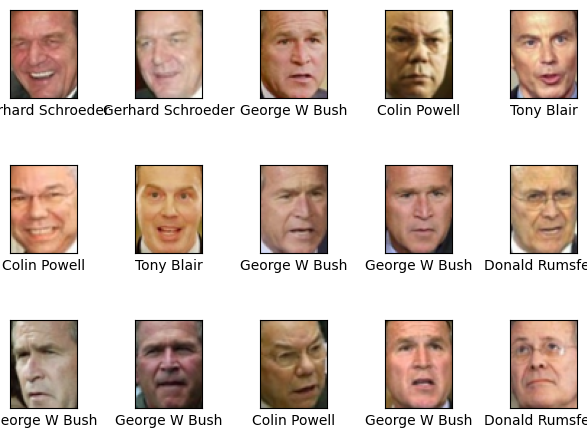

In [11]:
# Check by Plotted Images
# Generate random 15 images
rand_labels = [np.random.randint(0, len(faces.data)) for x in range(0,15)]

fig, ax = plt.subplots(3, 5)
fig.tight_layout()
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[rand_labels[i]], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[rand_labels[i]]])

## Step 4

We need to generate the histogram features for each channel. We do this by using the histogram function from numpy and then separating each channel so that we have read, green, and blue histogram.
After done splitting the histogram based on their colour channel, we concatenante the image into one, but not stackking them otherwise they'll return back to normal.

In [12]:
# Function Extract Histogram Features For Each Channel
def generate_hist(data, bins_num=5):
    hist_data = []

    for i in data:
        h_red = np.histogram(i[0][..., 0].ravel(), bins=bins_num)[0]
        h_green = np.histogram(i[1][..., 1].ravel(), bins=bins_num)[0]
        h_blue = np.histogram(i[2][..., 2].ravel(), bins=bins_num)[0]

        h_concat = np.concatenate((h_red, h_green, h_blue), axis=0) # Concat in row basis

        hist_data.append(h_concat)

    return np.array(hist_data)

In [13]:
# Extract histogram feature
hist_features = generate_hist(faces.images, bins_num=100)
hist_features.shape

(1348, 300)

## Step 5

This is where we begin training our model, for the first part, let's try to use the SVM approach first. We do this by using the SVC class from sklearn and then try different types of parameters using grid search. We do this by using the `GridSearchCV` from the sklearn library. This is used to find the most optimal parameters.

In [14]:
# Build a Model
X_train, X_test, y_train, y_test = train_test_split(hist_features, faces.target, test_size=0.3, random_state=42, stratify=faces.target)

svm_model = SVC(kernel='rbf', C=1, gamma='scale')
param_grid = {
    'C': [0.1, 1, 10, 100],            # Regularization parameter
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],  # Kernel coefficient for 'rbf'
    'kernel': ['linear', 'rbf', 'poly'],  # SVM kernel types
    'degree': [2, 3, 4],               # Only relevant for 'poly' kernel
    'class_weight': [None, 'balanced']  # Handle imbalanced classes
}

grid_search = GridSearchCV(svm_model, param_grid, verbose=2)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
[CV] END C=0.1, class_weight=None, degree=2, gamma=scale, kernel=linear; total time=   0.3s
[CV] END C=0.1, class_weight=None, degree=2, gamma=scale, kernel=linear; total time=   0.3s
[CV] END C=0.1, class_weight=None, degree=2, gamma=scale, kernel=linear; total time=   0.3s
[CV] END C=0.1, class_weight=None, degree=2, gamma=scale, kernel=linear; total time=   0.3s
[CV] END C=0.1, class_weight=None, degree=2, gamma=scale, kernel=linear; total time=   0.3s
[CV] END C=0.1, class_weight=None, degree=2, gamma=scale, kernel=rbf; total time=   0.3s
[CV] END C=0.1, class_weight=None, degree=2, gamma=scale, kernel=rbf; total time=   0.3s
[CV] END C=0.1, class_weight=None, degree=2, gamma=scale, kernel=rbf; total time=   0.2s
[CV] END C=0.1, class_weight=None, degree=2, gamma=scale, kernel=rbf; total time=   0.2s
[CV] END C=0.1, class_weight=None, degree=2, gamma=scale, kernel=rbf; total time=   0.2s
[CV] END C=0.1, class_weight=No

GridSearchCV(estimator=SVC(C=1),
             param_grid={'C': [0.1, 1, 10, 100],
                         'class_weight': [None, 'balanced'],
                         'degree': [2, 3, 4],
                         'gamma': ['scale', 'auto', 0.01, 0.1, 1],
                         'kernel': ['linear', 'rbf', 'poly']},
             verbose=2)

Here we use the most optimised model from the grid search and then try to predict the data based on the split data. Here we can see the accuracy from the SVM method is 99.75% on train data and 47.95% on test data. Decent, but not good enough, so let's try another algorithm.

In [7]:
best_model = grid_search.best_estimator_

# Evaluation
# Eval on Training
y_train_predict = best_model.predict(X_train)
acc_train = accuracy_score(y_train, y_train_predict)

# Eval on Test
y_test_predict = best_model.predict(X_test)
acc_test = accuracy_score(y_test, y_test_predict)

# Print
print(f'Accuracy on Train: {acc_train:.2%}')
print(f'Accuracy on Test: {acc_test:.2%}')

Accuracy on Train: 99.75%
Accuracy on Test: 47.95%


Here are some of the other summary report from the previous model we trained using the Support Vector Machine algorithm.

In [8]:
# Eval Classification Report
print(classification_report(y_test, y_test_predict, target_names=faces.target_names))

                   precision    recall  f1-score   support

     Colin Powell       0.42      0.39      0.41        71
  Donald Rumsfeld       0.00      0.00      0.00        36
    George W Bush       0.50      0.86      0.63       159
Gerhard Schroeder       0.00      0.00      0.00        33
       Tony Blair       0.00      0.00      0.00        43

         accuracy                           0.48       342
        macro avg       0.18      0.25      0.21       342
     weighted avg       0.32      0.48      0.38       342



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


This is the confusion matrix so that we know how the model perform when using the SVM algorithm.

Text(113.92222222222219, 0.5, 'predicted label')

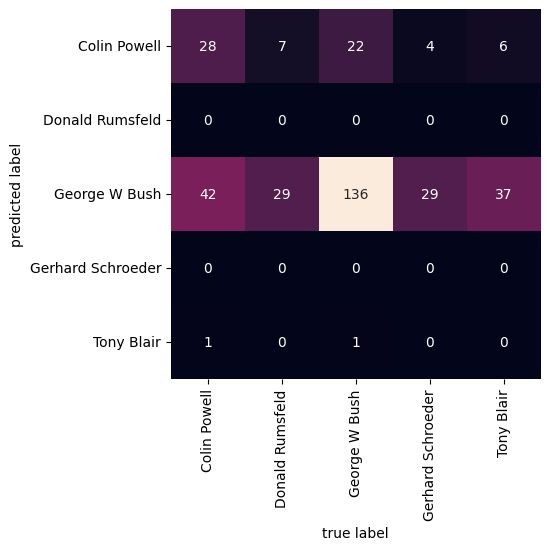

In [9]:
# Eval Confusion Matrix
# This is too large, we may not want it
mat = confusion_matrix(y_test, y_test_predict)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label')

For our other algorithm, let's try using another classification algorithm. The other common one apart from Support Vector Machine is Random Forest.

In [15]:
 # import the random forest algorithm from sklearn
 from sklearn.ensemble import RandomForestClassifier

In [17]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(hist_features, faces.target, test_size=0.3, random_state=42, stratify=faces.target)

rf_model = RandomForestClassifier()

# Define parameter grid for grid search
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Perform grid search with cross-validation
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5, n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train, y_train)

# Print the best parameters found by grid search
print("Best parameters found: ", grid_search_rf.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters found:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


After the best model has been found, try testing it on the train data and test data and see the accuracy.

In [18]:
best_rf_model = grid_search_rf.best_estimator_

# Evaluation
# Eval on Training
y_train_predict_rf = best_rf_model.predict(X_train)
acc_train_rf = accuracy_score(y_train, y_train_predict_rf)

# Eval on Test
y_test_predict_rf = best_rf_model.predict(X_test)
acc_test_rf = accuracy_score(y_test, y_test_predict_rf)

# Print
print(f'Accuracy on Train (RF): {acc_train_rf:.2%}')
print(f'Accuracy on Test (RF): {acc_test_rf:.2%}')


Accuracy on Train (RF): 100.00%
Accuracy on Test (RF): 41.23%


It seems that the accuracy is lower, for our next algorithm, let's try using the Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression

In [20]:
X_train, X_test, y_train, y_test = train_test_split(hist_features, faces.target, test_size=0.3, random_state=42, stratify=faces.target)

lr_model = LogisticRegression()

params_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

grid_search_lr = GridSearchCV(estimator=lr_model, param_grid=params_grid, cv=5, n_jobs=-1, verbose=2)
grid_search_lr.fit(X_train, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             verbose=2)

In [22]:
best_lr_model = grid_search_lr.best_estimator_

y_train_predict_lr = best_lr_model.predict(X_train)
acc_train_lr = accuracy_score(y_train, y_train_predict_lr)

y_test_predict_lr = best_lr_model.predict(X_test)
acc_test_lr = accuracy_score(y_test, y_test_predict_lr)

print(f'Accuracy on Train (LR): {acc_train_lr:.2%}')
print(f'Accuracy on Test (LR): {acc_test_lr:.2%}')

Accuracy on Train (LR): 47.19%
Accuracy on Test (LR): 41.73%
